In [ ]:
!pip install nltk
!python -m nltk.downloader averaged_perceptron_tagger
!python -m nltk.downloader wordnet omw-1.4 punkt

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt', download_dir='/root/nltk_data')
nltk.download('punkt_tab', download_dir='/root/nltk_data')
nltk.download('averaged_perceptron_tagger', download_dir='/root/nltk_data')
nltk.download('wordnet', download_dir='/root/nltk_data')
nltk.download('averaged_perceptron_tagger_eng', download_dir='/root/nltk_data')
nltk.download('stopwords', download_dir='/root/nltk_data')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# load dataset
df = pd.read_csv("human_ai_essays.csv", index_col=0)
print(len(df))

793


In [ ]:
df

,Question,Essay,AI Essay,Examiner_Commen,Overall
Unnamed: 0,,,,,
1,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,While many believe that wealthy nations should...,NaN,6.5
3,Rich countries often give money to poorer coun...,Human beings are facing many challenges nowada...,The issue of global poverty remains a serious ...,NaN,5.5
5,Some countries achieve international sports by...,Whether countries should only invest facilitie...,There is an ongoing debate about whether natio...,NaN,6.5
7,Some countries achieve international sports by...,"Sports is an essential part to most of us , so...",International sports success is often a source...,NaN,5.5
9,Some countries achieve international sports by...,International sports events require the most w...,Many nations choose to invest heavily in speci...,NaN,9.0
...,...,...,...,...,...
1430,Without capital punishment our lives are less ...,Serious crimes need capital punishment so that...,Some people believe that without capital punis...,"You should rewrite it, giving more thought to ...",5.0
1431,Some people think that they can learn better b...,It is certainly said that learning is an ongoi...,It is believed by some that learning alone is ...,Where are the paragraphs in this essay? You mu...,5.0
1432,Nowadays people like to change their day by da...,popular hobbies rather than their individual a...,"Today, many people are eager to adapt their da...",I suggest that you read several essays that ha...,5.0


<h2>Preprocessing</h2>

In [ ]:
def preprocess(df, label_non_alpha=True, lowercase=True, lemmatize=True, drop_stopwords=True):
    # copy the input DataFrame
    df2 = df.copy()

    # remove all nonalphabetic characters via regex
    currency_pattern = re.compile(r"\$[\d,]*\d+(?:\.?\d+)?")
    percent_pattern = re.compile(r"-?[\d,]*\d+(?:\.?\d+)?%")
    number_pattern = re.compile(r"-?[\d,]*\d+(?:\.?\d+)?")
    punctuation_pattern = re.compile(r"""[-.,:;’–`!?´'"“”()/‘]*""")

    def filter_characters(essay):
        if label_non_alpha:
            essay = re.sub(currency_pattern, 'CURRENCYPLACEHOLDER ', essay)
            essay = re.sub(percent_pattern, "PERCENTPLACEHOLDER ", essay)
            essay = re.sub(number_pattern, 'NUMBERPLACEHOLDER ', essay)
            essay = re.sub(punctuation_pattern, "", essay)
            essay = re.sub("[^a-zA-Z\s]", "SPECIALCHARPLACEHOLDER ", essay)
            essay = re.sub("\s+", " ", essay)
        else:
            essay = re.sub("[^a-zA-Z\s]", "", essay)
            essay = re.sub("\s+", " ", essay)
        return essay

    df2["Essay"] = df["Essay"].apply(filter_characters)
    df2["AI Essay"] = df["AI Essay"].apply(filter_characters)

    if lowercase:
        df2["Essay"] = df2["Essay"].str.lower()
        df2["AI Essay"] = df2["AI Essay"].str.lower()

    if lemmatize:
        def get_lemmas(essay):
            def treebank_to_wordnet(treebank_tag):
                if treebank_tag.startswith('J'):
                    return wordnet.ADJ
                elif treebank_tag.startswith('V'):
                    return wordnet.VERB
                elif treebank_tag.startswith('N'):
                    return wordnet.NOUN
                elif treebank_tag.startswith('R'):
                    return wordnet.ADV
                else:
                    return None

            lemmatizer = WordNetLemmatizer()
            if drop_stopwords:
              words = [word for word in word_tokenize(essay) if word not in nltk.corpus.stopwords.words('english')]
            else:
              words = word_tokenize(essay)
            pos_tags = nltk.pos_tag(words, lang="eng")

            lemmatized_words = []
            for word, pos in pos_tags:
                wn_pos = treebank_to_wordnet(pos) or wordnet.NOUN
                lemma = lemmatizer.lemmatize(word, wn_pos)
                lemmatized_words.append(lemma)

            return " ".join(lemmatized_words)

        df2["Essay"] = df2["Essay"].apply(get_lemmas)
        df2["AI Essay"] = df2["AI Essay"].apply(get_lemmas)

    return df2

In [ ]:
# df2 = preprocess(df)
df3 = preprocess(df, drop_stopwords=False)

In [ ]:
df5.to_csv("preprocessed_essays_no_placeholders")

In [ ]:
idx = np.random.choice(df2.index)
print(idx)
print(df2.loc[idx, "Essay"])

311
one important issue lot massive place earth mammoth food waste let discuss figure less problem firstly many reason like big celebration something popular happen lot also see adays restrants almost every people day like go always famous thing junk food cheap consequently visitor look fast thing busy others buy need hungry secondly help issue many way first know calorie eat need also spend much money reasrant make dreadful let body ask fast food however curcial buy stuff really need cook home move huge event significant make sure many people come breing food need want buy food must think sasted ask significant end important proplem take car start solve let human know problem


In [ ]:
df.loc[idx, "Essay"]

'one of the important issues of a lot of massive places on the earth is the mammoth food that is wasted let is discuss more about why and what we can figure out to less this problem.\nFirstly, there is many reasons, like the big celebrations which are something popular that happen a lot, also we can see that now adays restrants being almost every where so people these days like to go there always than before, and the most famous things is the junk food which is so cheap consequently more visitors that looking for a fast things because they are busy, while others who buy more than they need because they are hungry.\nSecondly, we can help that issues by many ways, first is by knowing your calories; you will eat just what you need, also do not spend much of money in reasrant because it makes you dreadful by let your body ask for more fast food however, it is curcial to only buy the stuff you really needed only and cook in your home, moving to the huge events it is significant to make sure

In [ ]:
a = 0
b = 3
c = a or b
print(c)

3


In [ ]:
# df3 = pd.read_csv("preprocessed_essays_with_stopwords.csv")

<h2>Feature Engineering</h2>

<h4>Word Count Analysis</h4>

In [ ]:
word_counts = {}
for essay in df3["Essay"] + df3["AI Essay"]:
  for word in essay.split(" "):
    if word in word_counts:
      word_counts[word] += 1
    else:
      word_counts[word] = 1

In [ ]:
print(max(word_counts.values()))

16548


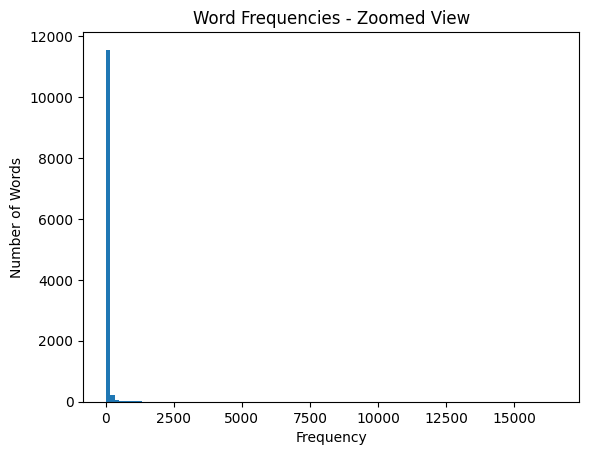

In [ ]:
plt.title("Word Frequencies - Zoomed View")
plt.hist(word_counts.values(), bins = 100)
plt.ylabel("Number of Words")
plt.xlabel("Frequency")
# plt.xlim(0, 50)
plt.show()

In [ ]:
total = 0
# for ct in sorted(word_counts.values(), reverse=True)[:int(0.117*len(word_counts))]:
for ct in sorted(word_counts.values(), reverse=True)[:100]:
  total += ct
print(total)
print(total / sum(word_counts.values()))

41140
0.3134930008915576


In [ ]:
threshold = 1
less_than_threshold = 0
for ct in word_counts.values():
  if ct <= threshold:
    less_than_threshold += 1
print(less_than_threshold)
print(less_than_threshold / len(word_counts))

4578
0.45725129844186974


In [ ]:
0.117 * len(word_counts)

1171.404

In [ ]:
word_counts = {}
for essay in df2["AI Essay"]:
  for word in essay.split(" "):
    if word in word_counts:
      word_counts[word] += 1
    else:
      word_counts[word] = 1

In [ ]:
len(word_counts)

5522

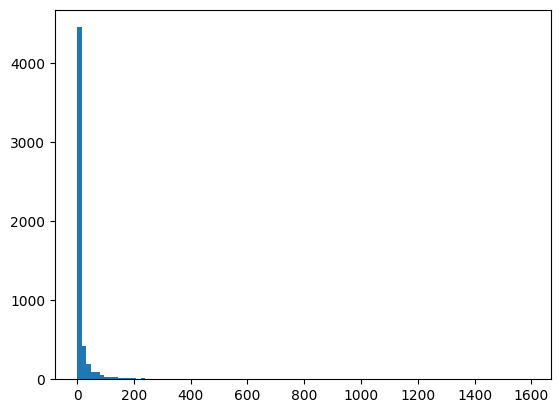

In [ ]:
plt.hist(word_counts.values(), bins=100)
plt.show()

In [ ]:
total = 0
# for ct in sorted(word_counts.values(), reverse=True)[:int(0.117*len(word_counts))]:
for ct in sorted(word_counts.values(), reverse=True)[:100]:
  total += ct
print(total)
print(total / sum(word_counts.values()))

31022
0.3250078575170246


In [ ]:
threshold = 1
less_than_threshold = 0
for ct in word_counts.values():
  if ct <= threshold:
    less_than_threshold += 1
print(less_than_threshold)
print(less_than_threshold / len(word_counts))

1907
0.3453458891705904


<h4>Train Test Split</h4>

In [ ]:
train_df, test_df = train_test_split(df3, test_size=100, random_state=7934642)
# train_df.to_csv("preprocessed_train_without_placeholders.csv")
# test_df.to_csv("preprocessed_test_without_placeholders.csv")

<h4>Co-occurence Matrices</h4>

In [ ]:
class MatrixBuilder(object):
  def __init__(self):
    self.is_fit = False
    self.words = None
    self.tfidf = None
    self.num_words = None
    self.covar = None

  def fit(self, essays, num_words=100):
    self.num_words = num_words

    # get word count matrix
    word_counts = {}
    for essay in essays:
      for word in essay.split(" "):
        if word in word_counts:
          word_counts[word] += 1
        else:
          word_counts[word] = 1

    # sort the word count matrix and retain the most common 'num_words' words
    self.words = sorted(word_counts.keys(), key=lambda value: word_counts[value], reverse=True)[:num_words]
    self.is_fit = True

    # fit the TFIDF vectorizer object
    self.tfidf = TfidfVectorizer(vocabulary=self.words)
    self.tfidf.fit(essays)

    # create frequencies covariance array
    self.covar = np.cov([[float(word in essay) for essay in essays] for word in self.words])

  def build_matrix(self, essay):
    matrix = np.zeros((self.num_words, self.num_words))

    # construct matrix diagonal
    tfidf_values = self.tfidf.transform([essay])
    for i, word in enumerate(self.words):
      matrix[i, i] = tfidf_values[0, i]

    # construct lower triangular component
    words = essay.split(" ")
    for i, word_1 in enumerate(self.words):
      for j, word_2 in enumerate(self.words):
        if j >= i: # only fill in lower triangular component
          continue
        else:
          ct_1 = words.count(word_1)
          ct_2 = words.count(word_2)
          matrix[i, j] = max(ct_1, ct_2) if min(ct_1, ct_2) > 0 else 0

    # construct upper triangular component
    for i in range(self.num_words):
      for j in range(self.num_words):
        if j <= i:
          continue
        else:
          matrix[i, j] = self.covar[i, j] / self.covar[i, i] / self.covar[j, j]
          matrix[i, j] = (1 + matrix[j, i]) / matrix[i, j]

    return matrix.reshape(1, -1)


  def transform(self, df):
    if not self.is_fit:
      raise Exception("MatrixBuilder not fit")

    X = np.empty((2*len(df), self.num_words**2))
    y = np.empty(2*len(df))
    z = np.empty(2*len(df)) # indices in df corresponding to this row in X and y

    for i, idx in tqdm(enumerate(df.index)):
      essay = df.loc[idx, "Essay"]
      ai_essay = df.loc[idx, "AI Essay"]

      X[2*i, :] = self.build_matrix(essay)
      X[2*i+1, :] = self.build_matrix(ai_essay)

      y[2*i] = 0
      y[2*i+1] = 1

      z[2*i] = idx
      z[2*i+1] = idx

    return X, y, z

In [ ]:
matrix_builder = MatrixBuilder()
matrix_builder.fit(train_df["Essay"] + train_df["AI Essay"], num_words=100)
X_train, y_train, train_indices = matrix_builder.transform(train_df)

# matrix_builder_test = MatrixBuilder()
# matrix_builder_test.fit(test_df["Essay"] + test_df["AI Essay"], num_words=100)
# X_test, y_test, test_indices = matrix_builder_test.transform(test_df)

0it [00:00, ?it/s]<ipython-input-39-70a3b8947978>:57: RuntimeWarning: invalid value encountered in scalar divide
  matrix[i, j] = self.covar[i, j] / self.covar[i, i] / self.covar[j, j]
693it [01:48,  6.39it/s]


In [ ]:
[word for word in matrix_builder.words[:50] if word in set(nltk.corpus.stopwords.words('english'))]

['the',
 'be',
 'to',
 'and',
 'a',
 'of',
 'in',
 'that',
 'for',
 'it',
 'have',
 'can',
 'their',
 'this',
 'on',
 'or',
 'more',
 'they',
 'with',
 'not',
 'i',
 'some',
 'by',
 'should',
 'from',
 'which',
 'will',
 'there',
 'other',
 'such',
 'do',
 'an',
 'them',
 'if',
 'but',
 'while']

In [ ]:
np.save("X_train_without_placeholders.npy", X_train)
np.save("y_train_without_placeholders.npy", y_train)

np.save("X_test_without_placeholders.npy", X_test)
np.save("y_test_without_placeholders.npy", y_test)

In [ ]:
print(X_train.shape)

(1386, 36)


In [ ]:
def plot_matrix(X_train, i):
  X = X_train.copy()

  # rescale for plotting purposes
  min_val = X.min()
  max_val = X.max()
  image = (X[i] - min_val) / (max_val - min_val)

  # plot
  n = int(X.shape[1] ** 0.5)
  plt.imshow(image.reshape(n, n), vmin=0, vmax=1, cmap="gray")
  plt.axis("off")
  plt.show()

  # print for debugging purposes
  print(image.reshape(n, n))

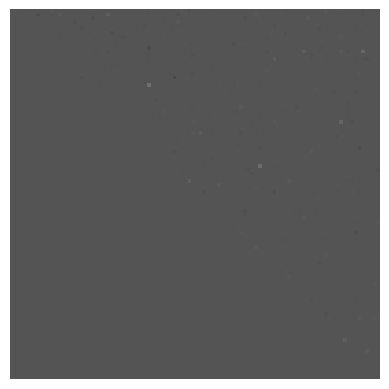

[[0.32897877 0.32858841 0.32918615 ... 0.32998249 0.32774202 0.32590933]
 [0.32918348 0.32899518 0.32890363 ... 0.33105341 0.3298781  0.3286075 ]
 [0.32897359 0.32897359 0.32897359 ... 0.32915437 0.3288481  0.32864872]
 ...
 [0.32897359 0.32897359 0.32897359 ... 0.32897359 0.32885882 0.32945625]
 [0.32907853 0.32918348 0.32897359 ... 0.32897359 0.32897764 0.32846206]
 [0.32897359 0.32897359 0.32897359 ... 0.32897359 0.32897359 0.32897359]]


In [ ]:
# rescale pixel values to fall within uniform range
plot_matrix(X_train, 0)

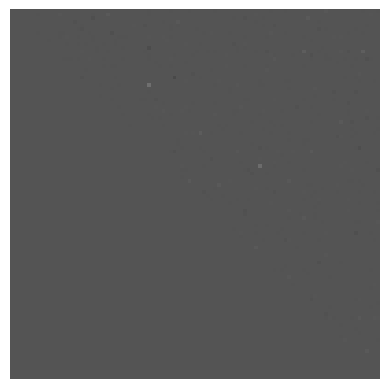

[[0.32897359 0.32891856 0.32918615 ... 0.32998249 0.3286657  0.32590933]
 [0.32897359 0.32898556 0.32890363 ... 0.33521305 0.3291028  0.3286075 ]
 [0.32897359 0.32897359 0.32897359 ... 0.32915437 0.3288481  0.32864872]
 ...
 [0.32897359 0.32904355 0.32897359 ... 0.32898025 0.32885882 0.32945625]
 [0.32897359 0.32897359 0.32897359 ... 0.32897359 0.32897359 0.32846206]
 [0.32897359 0.32897359 0.32897359 ... 0.32897359 0.32897359 0.32897359]]


In [ ]:
plot_matrix(X_train, 1)

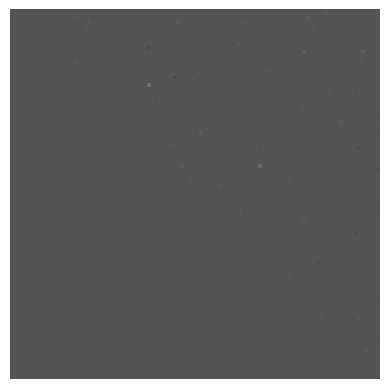

[[0.32897359 0.32891856 0.32918615 ... 0.32998249 0.3286657  0.32590933]
 [0.32897359 0.32897359 0.32890363 ... 0.33105341 0.3291028  0.3286075 ]
 [0.32897359 0.32897359 0.32897359 ... 0.32915437 0.3288481  0.32864872]
 ...
 [0.32897359 0.32897359 0.32897359 ... 0.32897359 0.32885882 0.32945625]
 [0.32897359 0.32897359 0.32897359 ... 0.32897359 0.32897359 0.32846206]
 [0.32897359 0.32897359 0.32897359 ... 0.32897359 0.32897359 0.32897359]]


In [ ]:
plot_matrix(X_train, 2)

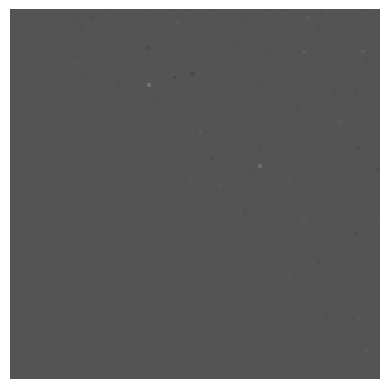

[[0.32897359 0.32891856 0.32918615 ... 0.32998249 0.3286657  0.32590933]
 [0.32897359 0.32897359 0.32890363 ... 0.33105341 0.3291028  0.3286075 ]
 [0.32897359 0.32897359 0.32897359 ... 0.32915437 0.3288481  0.32864872]
 ...
 [0.32897359 0.32897359 0.32897359 ... 0.32897359 0.32885882 0.32945625]
 [0.32897359 0.32897359 0.32897359 ... 0.32897359 0.32897359 0.32846206]
 [0.32897359 0.32897359 0.32897359 ... 0.32897359 0.32897359 0.32897359]]


In [ ]:
plot_matrix(X_train, 3)

In [ ]:
for i in range(int(X_train.shape[0] / 2)):
  if np.allclose(X_train[2*i], X_train[2*i+1]):
    print(i)

1
94
178
368
433
652


In [ ]:
np.diag(X_train)

array([  0.14823654,  -1.57298782,   6.07647622, ...,   9.13195229,
       -10.7411117 , -48.58210072])

In [ ]:
from scipy.stats import t
import numpy as np

y_correct = np.load("")